<div style="position: absolute; top: 0; left: 0; font-family: 'Garamond'; font-size: 16px;">
    <a href="https://github.com/patriciaapenat" style="text-decoration: none; color: inherit;">Patricia Peña Torres</a>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 48px;">
    <strong>Proyecto final, BRFSS-clustering</strong>
</div>

<div align="center" style="font-family: 'Garamond'; font-size: 36px;">
    <strong>0.2. Análisis exploratorio</strong>
</div>

__________________

<div style="font-family: 'Garamond'; font-size: 14px;">

En este notebook se llava a cabo lo relativo al análisis exploratorio, por la naturaleza de los datos este EDA se ha centrado principalmente en variables demográficas
    
</div>

<div style="font-family: 'Garamond'; font-size: 16px;">
    <strong>Configuración del entorno de trabajo</strong>
</div>

In [1]:
import pandas as pd
import findspark
findspark.init()
import pyspark
import random
import os.path
import seaborn as sns
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os
from pyspark.sql import DataFrame
import pickle
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
import pyspark.sql.functions as F
from pyspark.ml.feature import Imputer
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import tensorflow as tf
import numpy as np
import warnings
from pyspark.ml import Pipeline

# Ignorar advertencias deprecated
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# configurar gráficos
sns.set(style="whitegrid", context="notebook", palette="mako")

<div style="font-family: 'Garamond'; font-size: 14px;">
    <strong>Configuración de Spark</strong>
</div>

In [3]:
# Si hay un SparkContext existente, debemos cerrarlo antes de crear uno nuevo
if 'sc' in locals() and sc:
    sc.stop()  # Detener el SparkContext anterior si existe

# Configuración de Spark
conf = (
    SparkConf()
    .setAppName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .setMaster("local[1]")  # Modo local con un hilo para ejecución
    .set("spark.driver.host", "127.0.0.1")  # Dirección del host del driver
    .set("spark.executor.heartbeatInterval", "3600s")  # Intervalo de latido del executor
    .set("spark.network.timeout", "7200s")  # Tiempo de espera de la red
    .set("spark.executor.memory", "14g")  # Memoria asignada para cada executor
    .set("spark.driver.memory", "14g")  # Memoria asignada para el driver
)

# Crear un nuevo SparkContext con la configuración especificada
sc = SparkContext(conf=conf)

# Configuración de SparkSession (interfaz de alto nivel para trabajar con datos estructurados en Spark)
spark = (
    SparkSession.builder
    .appName("Proyecto_PatriciaA_Peña")  # Nombre de la aplicación en Spark
    .config("spark.sql.repl.eagerEval.enabled", True)  # Habilitar la evaluación perezosa en Spark SQL REPL
    .config("spark.sql.repl.eagerEval.maxNumRows", 1000)  # Número máximo de filas a mostrar en la evaluación perezosa
    .getOrCreate()  # Obtener la sesión Spark existente o crear una nueva si no existe
) 

<div style="font-family: 'Garamond'; font-size: 14px;">
    <strong>Lectura del archivo</strong>
</div>

In [4]:
df = spark.read.format("csv").option("header", "true").load(r"C:\\Users\\patri\\OneDrive - UAB\\Documentos\\GitHub\\BRFSS-clustering\\datos\\BRFSS_imputated_2022.csv")

In [5]:
# Convertir todas las columnas a tipo numérico
for column_name in df.columns:
    df = df.withColumn(column_name, col(column_name).cast("double"))

In [6]:
# Suponiendo que tienes un DataFrame de Spark llamado df con las características numéricas
columnas_features = [col for col in df.columns if col != "etiqueta"]
ensamblador = VectorAssembler(inputCols=columnas_features, outputCol="features")
df_con_features = ensamblador.transform(df).select("features")

In [7]:
# Convertir el DataFrame de Spark a un array NumPy
features_array = np.array(df_con_features.rdd.map(lambda x: x.features.toArray()).collect())

In [8]:
# Definir el autoencoder utilizando TensorFlow
input_dim = len(columnas_features)
encoding_dim = 4  # Dimensión reducida deseada

In [9]:
# Definir la arquitectura del autoencoder
input_layer = tf.keras.layers.Input(shape=(input_dim,))
encoder = tf.keras.layers.Dense(encoding_dim, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01))(input_layer)
decoder = tf.keras.layers.Dense(input_dim, activation='relu')(encoder)

In [10]:
# Crear el modelo del autoencoder
autoencoder = tf.keras.models.Model(inputs=input_layer, outputs=decoder)

In [11]:
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [12]:
# Entrenar el autoencoder
autoencoder.fit(features_array, features_array, epochs=50, batch_size=32)

Epoch 1/50
11348/11348 [==============================] - 34s 3ms/step - loss: 198710352.0000
Epoch 2/50
11348/11348 [==============================] - 37s 3ms/step - loss: 196787824.0000
Epoch 3/50
11348/11348 [==============================] - 34s 3ms/step - loss: 196787136.0000
Epoch 4/50
11348/11348 [==============================] - 33s 3ms/step - loss: 196787488.0000
Epoch 5/50
11348/11348 [==============================] - 35s 3ms/step - loss: 196787392.0000
Epoch 6/50
11348/11348 [==============================] - 35s 3ms/step - loss: 196786960.0000
Epoch 7/50
11348/11348 [==============================] - 33s 3ms/step - loss: 196787248.0000
Epoch 8/50
11348/11348 [==============================] - 33s 3ms/step - loss: 196787456.0000
Epoch 9/50
11348/11348 [==============================] - 37s 3ms/step - loss: 196787344.0000
Epoch 10/50
11348/11348 [==============================] - 33s 3ms/step - loss: 196787088.0000
Epoch 11/50
11348/11348 [==============================] - 

In [13]:
# Obtener las representaciones codificadas de los datos
encoded_features_model = tf.keras.models.Model(inputs=input_layer, outputs=encoder)
encoded_features = encoded_features_model.predict(features_array)

11348/11348 [==============================] - 26s 2ms/step


In [14]:
from pyspark.ml.linalg import Vectors

# Convertir las representaciones codificadas de vuelta a un DataFrame de Spark
encoded_features_rdd = spark.sparkContext.parallelize(encoded_features.tolist())
encoded_features_df = encoded_features_rdd.map(lambda x: (Vectors.dense(x),)).toDF(["encoded_features"])

In [15]:
# Entrenar el autoencoder
history = autoencoder.fit(features_array, features_array, epochs=50, batch_size=32)

# Imprimir métricas durante el entrenamiento
print("Métricas durante el entrenamiento:")
print(history.history)

Epoch 1/50
11348/11348 [==============================] - 31s 3ms/step - loss: 196787248.0000
Epoch 2/50
11348/11348 [==============================] - 31s 3ms/step - loss: 196787440.0000
Epoch 3/50
11348/11348 [==============================] - 34s 3ms/step - loss: 196787456.0000
Epoch 4/50
11348/11348 [==============================] - 31s 3ms/step - loss: 196787120.0000
Epoch 5/50
11348/11348 [==============================] - 31s 3ms/step - loss: 196787392.0000
Epoch 6/50
11348/11348 [==============================] - 33s 3ms/step - loss: 196787120.0000
Epoch 7/50
11348/11348 [==============================] - 33s 3ms/step - loss: 196787024.0000
Epoch 8/50
11348/11348 [==============================] - 31s 3ms/step - loss: 196786704.0000
Epoch 9/50
11348/11348 [==============================] - 32s 3ms/step - loss: 196787600.0000
Epoch 10/50
11348/11348 [==============================] - 35s 3ms/step - loss: 196786928.0000
Epoch 11/50
11348/11348 [==============================] - 

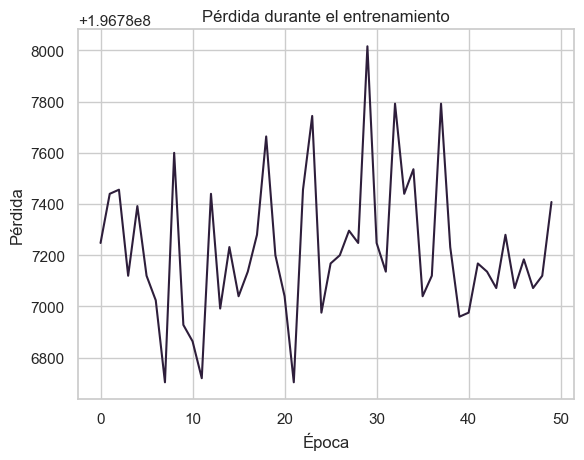

In [16]:
import matplotlib.pyplot as plt

# Visualizar la pérdida durante el entrenamiento
plt.plot(history.history['loss'])
plt.title('Pérdida durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.show()

In [17]:
# Suponiendo que `encoded_features_df` contiene las representaciones codificadas de tus datos
# Convertir el DataFrame de Spark a un array NumPy
encoded_features_array = np.array(encoded_features_df.select("encoded_features").rdd.map(lambda x: x.encoded_features.toArray()).collect())

In [19]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [25]:
# Construir el árbol KD
kdtree = KDTree(encoded_features_array)

# Definir el radio de búsqueda (epsilon)
epsilon = 0.5

# Crear una lista para almacenar las etiquetas de cluster
cluster_labels = []


In [26]:
# Para cada punto en tus datos, buscar vecinos dentro del radio epsilon
for i in range(len(encoded_features_array)):
    neighbors = kdtree.query_radius([encoded_features_array[i]], r=epsilon)
    # Si el número de vecinos es mayor o igual al número mínimo de muestras para formar un cluster
    if len(neighbors[0]) >= min_samples:
        # Asignar una etiqueta de cluster
        cluster_labels.append(len(cluster_labels) + 1)
    else:
        # Asignar una etiqueta de ruido (-1)
        cluster_labels.append(-1)

In [29]:
from pyspark.sql.functions import lit, monotonically_increasing_id

# Agregar las etiquetas de cluster al DataFrame original
encoded_features_df = encoded_features_df.withColumn("cluster_label", lit(cluster_labels))

In [30]:
# Mostrar el DataFrame resultante
encoded_features_df.show()

+--------------------+--------------------+
|    encoded_features|       cluster_label|
+--------------------+--------------------+
|[204313.90625,244...|[1, -1, -1, -1, -...|
|[204318.515625,24...|[1, -1, -1, -1, -...|
|[390545.09375,467...|[1, -1, -1, -1, -...|
|[204326.375,24446...|[1, -1, -1, -1, -...|
|[204317.875,24446...|[1, -1, -1, -1, -...|
|[204314.8125,2444...|[1, -1, -1, -1, -...|
|[25669.431640625,...|[1, -1, -1, -1, -...|
|[204319.875,24446...|[1, -1, -1, -1, -...|
|[204317.25,244465...|[1, -1, -1, -1, -...|
|[204312.796875,24...|[1, -1, -1, -1, -...|
|[204319.8125,2444...|[1, -1, -1, -1, -...|
|[204324.453125,24...|[1, -1, -1, -1, -...|
|[204321.0625,2444...|[1, -1, -1, -1, -...|
|[204322.390625,24...|[1, -1, -1, -1, -...|
|[204319.359375,24...|[1, -1, -1, -1, -...|
|[204322.625,24440...|[1, -1, -1, -1, -...|
|[204317.46875,244...|[1, -1, -1, -1, -...|
|[204324.53125,244...|[1, -1, -1, -1, -...|
|[204316.703125,24...|[1, -1, -1, -1, -...|
|[204315.28125,244...|[1, -1, -1

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Suponiendo que `encoded_features_array` contiene las representaciones codificadas de tus datos
# y `cluster_labels` contiene las etiquetas de clúster asignadas por DBSCAN

# Reducir la dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_encoded_features = tsne.fit_transform(encoded_features_array)

# Crear un DataFrame de pandas para la visualización
tsne_df = pd.DataFrame(tsne_encoded_features, columns=['Componente 1', 'Componente 2'])
tsne_df['Cluster'] = cluster_labels

# Visualizar los clústeres en un gráfico de dispersión
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Componente 1', y='Componente 2', hue='Cluster', data=tsne_df, palette='mako', legend='full')
plt.title('Visualización de Clústeres con t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Cluster')
plt.show()


In [ ]:
# Suponiendo que `encoded_features_array` contiene las representaciones codificadas de tus datos
# y `cluster_labels` contiene las etiquetas de clúster asignadas por DBSCAN

# Reducir la dimensionalidad con t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_encoded_features = tsne.fit_transform(encoded_features_array)

# Crear un DataFrame de pandas para la visualización
tsne_df = pd.DataFrame(tsne_encoded_features, columns=['Componente 1', 'Componente 2'])
tsne_df['Cluster'] = cluster_labels

# Filtrar los datos para visualizar solo los cuatro clústeres
tsne_df_filtered = tsne_df[tsne_df['Cluster'] >= 0]  # Solo considerar clústeres con etiquetas positivas

# Visualizar los clústeres en un gráfico de dispersión
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Componente 1', y='Componente 2', hue='Cluster', data=tsne_df_filtered, palette='mako', legend='full')
plt.title('Visualización de Clústeres con t-SNE')
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.legend(title='Cluster')
plt.show()
